In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## Loan Payback Prediction|ML|EDA

## Description: 
This project aims to predict the likelihood of a borrower repaying their loan using historical loan application and repayment data. Leveraging advanced machine learning techniques, including LightGBM, we analyze both numerical features (income, credit score, loan amount, interest rate, debt-to-income ratio) and categorical features (gender, marital status, education, employment status, loan purpose, grade/subgrade).

The model not only provides probability scores for repayment but also offers interpretable insights via:

Feature importance analysis to identify key drivers of repayment behavior.

Distribution plots for predicted probabilities to understand risk levels.

Correlation and interaction exploration among financial features.

In [2]:
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#30363d'
plt.rcParams['grid.color'] = '#21262d'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#8b949e'
plt.rcParams['ytick.color'] = '#8b949e'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# --- Unique Cyber Neon Glow Palette ---
neon_glow_palette = [
    "#00f5d4",  # Neon aqua
    "#00bbf9",  # Electric blue
    "#9b5de5",  # Digital purple
    "#ff99c8",  # Soft neon pink
    "#f15bb5",  # Hot magenta
    "#fee440",  # Neon yellow
]

sns.set_palette(neon_glow_palette)


## Import dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

In [4]:
target_col = train_df.columns.tolist()[-1]

In [5]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
train_df.head()

Training data shape: (593994, 13)
Test data shape: (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [7]:
test_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [9]:
train_df.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

In [10]:
train_df.shape

(593994, 13)

In [11]:
train_df.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [12]:
train_df.nunique()

id                      593994
annual_income           119728
debt_to_income_ratio       526
credit_score               399
loan_amount             111570
interest_rate             1454
gender                       3
marital_status               4
education_level              5
employment_status            5
loan_purpose                 8
grade_subgrade              30
loan_paid_back               2
dtype: int64

In [13]:
train_df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [14]:
test_df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade'],
      dtype='object')

## EDA

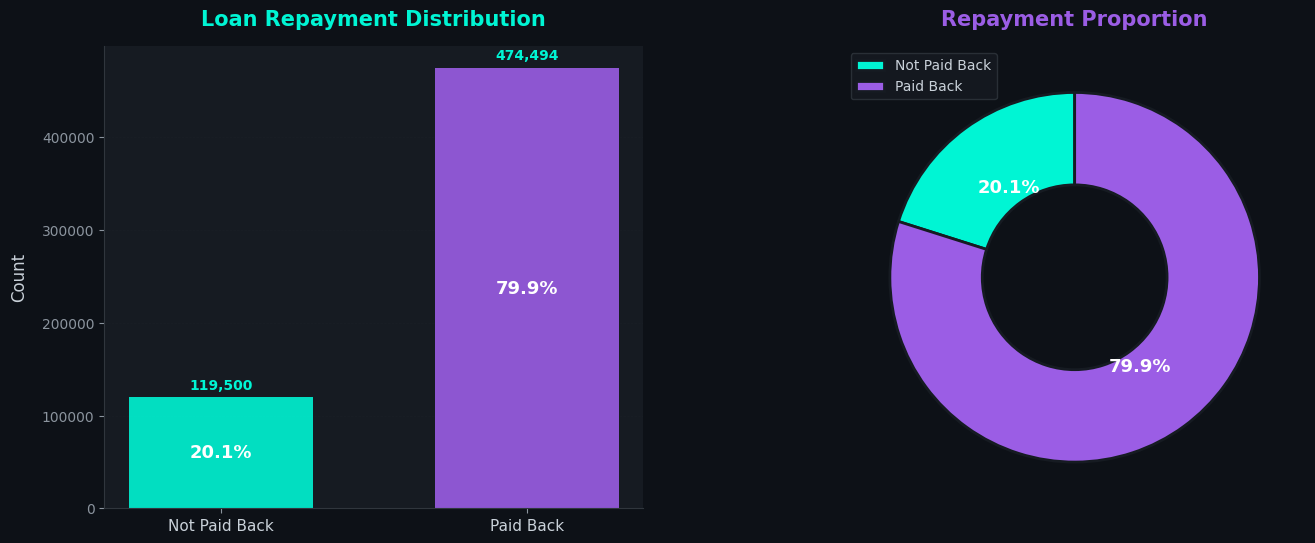


Class Distribution:
Paid Back: 474,494 (79.88%)
Not Paid Back: 119,500 (20.12%)


In [15]:
# New unique neon colors
neon_colors = ["#00f5d4", "#9b5de5"]

fig = plt.figure(figsize=(16, 6), facecolor='#0d1117')
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

# Count plot with modern styling
ax1 = fig.add_subplot(gs[0, 0])
target_counts = train_df[target_col].value_counts().sort_index()
x_pos = np.arange(len(target_counts))

bars = ax1.bar(
    x_pos,
    target_counts.values,
    width=0.6,
    color=neon_colors,       # <-- Updated colors here
    edgecolor='none',
    alpha=0.9
)

# Bar enhancements
for i, bar in enumerate(bars):
    bar.set_linewidth(0)
    bar.set_zorder(2)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Not Paid Back', 'Paid Back'], fontsize=11, color='#c9d1d9')
ax1.set_ylabel('Count', fontsize=12, color='#c9d1d9', labelpad=10)
ax1.set_title('Loan Repayment Distribution', fontsize=15, color='#00f5d4',
              pad=15, weight='600')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#30363d')
ax1.spines['bottom'].set_color('#30363d')
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# Value labels
total = len(train_df)
for i, (bar, count) in enumerate(zip(bars, target_counts.values)):
    height = bar.get_height()

    ax1.text(
        bar.get_x() + bar.get_width() / 2., height + total * 0.01,
        f'{count:,}', ha='center', va='bottom',
        color='#00f5d4', fontsize=10, weight='600'
    )

    ax1.text(
        bar.get_x() + bar.get_width() / 2., height / 2,
        f'{count / total * 100:.1f}%', ha='center', va='center',
        color='#ffffff', fontsize=13, weight='700'
    )

# Donut chart
ax2 = fig.add_subplot(gs[0, 1])

wedges, texts, autotexts = ax2.pie(
    target_counts.values,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=neon_colors,    # <-- Updated colors here
    wedgeprops=dict(width=0.5, edgecolor='#161b22', linewidth=2)
)

for autotext in autotexts:
    autotext.set_color('#ffffff')
    autotext.set_fontsize(13)
    autotext.set_weight('700')

ax2.set_title('Repayment Proportion', fontsize=15, color='#9b5de5',
              pad=15, weight='600')

ax2.legend(
    ['Not Paid Back', 'Paid Back'],
    loc='upper left',
    frameon=True,
    facecolor='#161b22',
    edgecolor='#30363d',
    fontsize=10,
    labelcolor='#c9d1d9'
)

plt.tight_layout()
plt.show()

# Print values
print("\nClass Distribution:")
print(f"Paid Back: {target_counts[1]:,} ({target_counts[1]/total*100:.2f}%)")
print(f"Not Paid Back: {target_counts[0]:,} ({target_counts[0]/total*100:.2f}%)")


## Numarical features distribution

In [16]:
numerical_cols = ['annual_income', 'credit_score', 'loan_amount', 'interest_rate', 'debt_to_income_ratio']

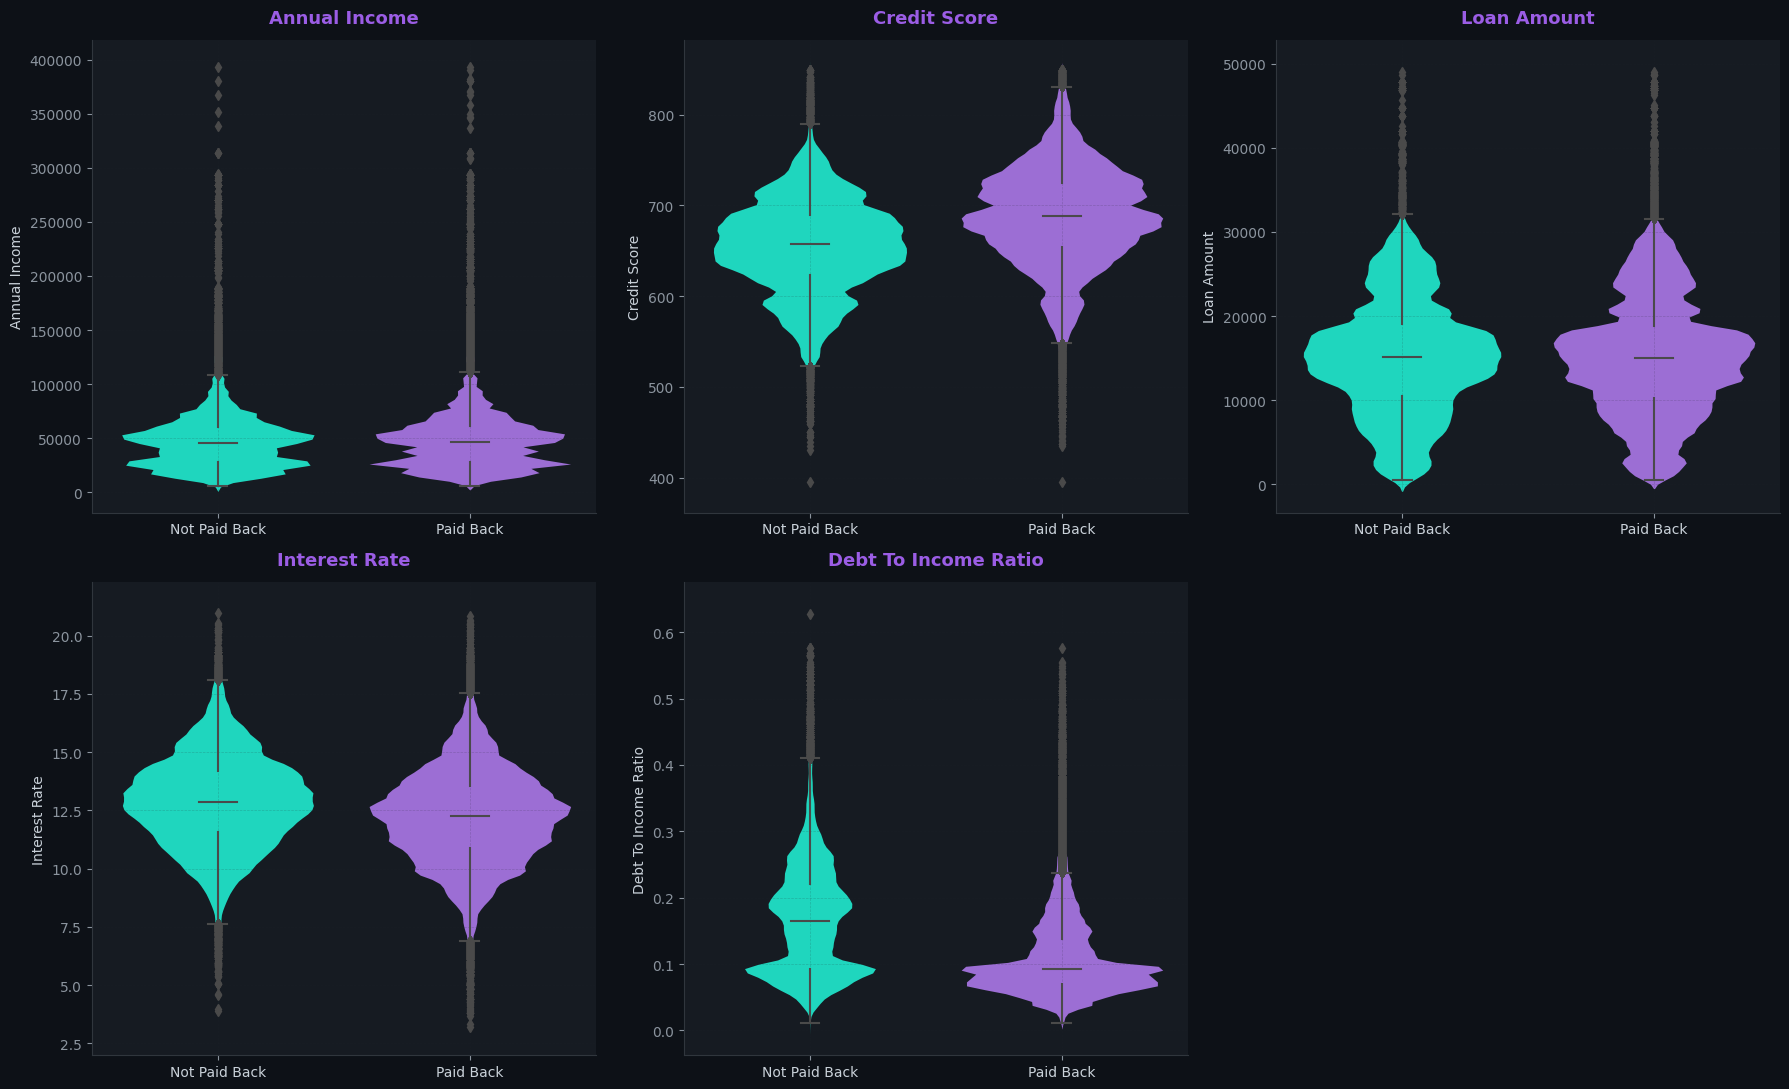

In [17]:
# Neon colors for classes
colors = {
    0: "#00f5d4",   # Not Paid Back
    1: "#9b5de5"    # Paid Back
}

fig, axes = plt.subplots(2, 3, figsize=(18, 11), facecolor="#0d1117")
fig.subplots_adjust(hspace=0.35, wspace=0.3)
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    
    # Violin plot
    sns.violinplot(
        data=train_df,
        x=target_col,
        y=col,
        palette=[colors[0], colors[1]],
        inner=None,
        linewidth=0,
        ax=ax
    )
    
    # Boxplot overlay
    sns.boxplot(
        data=train_df,
        x=target_col,
        y=col,
        palette=[colors[0], colors[1]],
        width=0.15,
        boxprops=dict(alpha=0.5),
        ax=ax
    )

    # Axes labels
    ax.set_title(col.replace('_', ' ').title(),
                 fontsize=13, color="#9b5de5", pad=12, weight="600")
    
    ax.set_xlabel("")
    ax.set_ylabel(col.replace('_', ' ').title(),
                  fontsize=10, color="#c9d1d9")
    
    # Replace class numbers with readable labels
    ax.set_xticklabels(['Not Paid Back', 'Paid Back'],
                       fontsize=10, color="#c9d1d9")
    
    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#30363d')
    ax.spines['bottom'].set_color('#30363d')
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Remove last empty subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()


## Heatmap

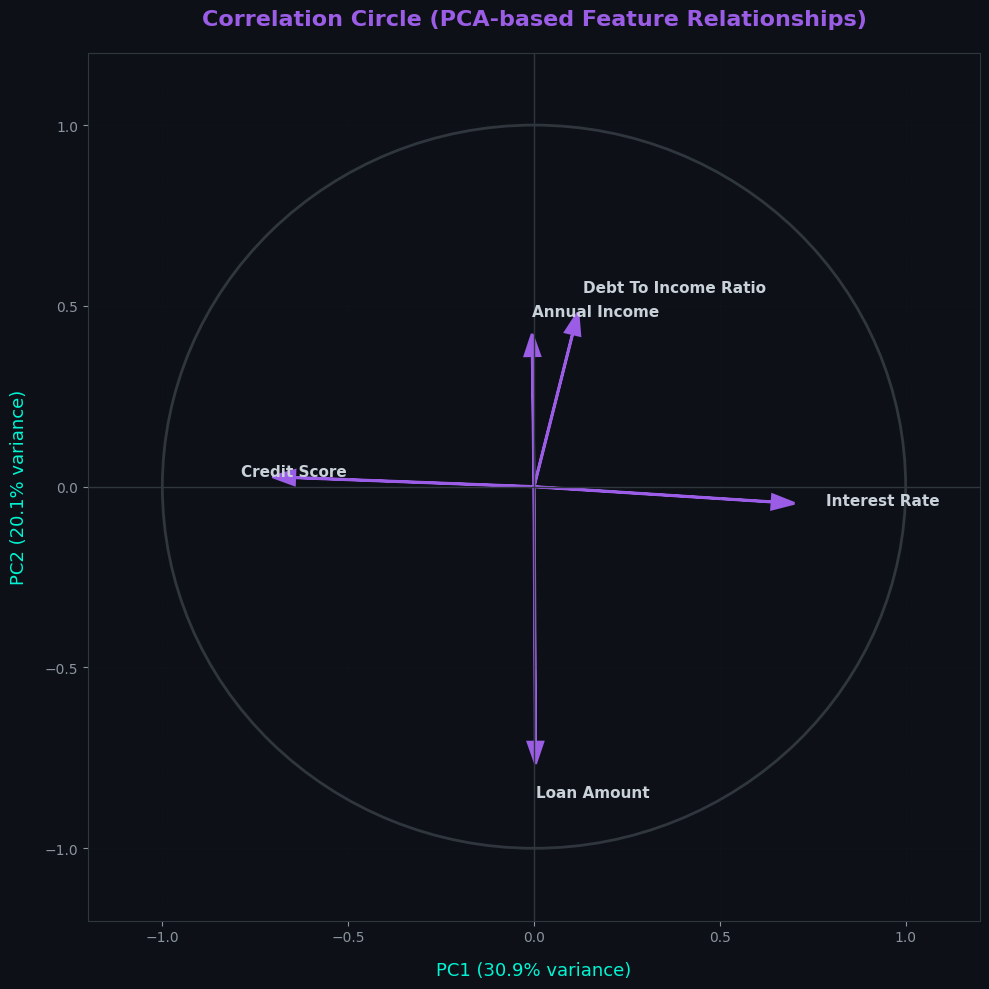

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------- PREPARE DATA --------
X = train_df[numerical_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)

pc1 = pca.components_[0]
pc2 = pca.components_[1]

expl_var = pca.explained_variance_ratio_ * 100

# -------- PLOT STYLE --------
fig, ax = plt.subplots(figsize=(10, 10), facecolor="#0d1117")
ax.set_facecolor("#0d1117")

# Neon colors
color = "#00f5d4"

# Draw circle
circle = plt.Circle((0, 0), 1, color="#30363d", fill=False, linewidth=2)
ax.add_artist(circle)

# Axes lines
ax.axhline(0, color="#30363d", linewidth=1)
ax.axvline(0, color="#30363d", linewidth=1)

# -------- ARROWS FOR FEATURES --------
for i, feature in enumerate(numerical_cols):
    ax.arrow(0, 0, pc1[i], pc2[i],
             head_width=0.04, color="#9b5de5", linewidth=2, length_includes_head=True)

    ax.text(pc1[i] * 1.12, pc2[i] * 1.12,
            feature.replace("_", " ").title(),
            color="#c9d1d9", fontsize=11, weight="600")

# -------- LABELS --------
ax.set_xlabel(f"PC1 ({expl_var[0]:.1f}% variance)",
              fontsize=13, color="#00f5d4", labelpad=12)
ax.set_ylabel(f"PC2 ({expl_var[1]:.1f}% variance)",
              fontsize=13, color="#00f5d4", labelpad=12)

ax.set_title("Correlation Circle (PCA-based Feature Relationships)",
             fontsize=16, color="#9b5de5", pad=20, weight="600")

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

ax.grid(alpha=0.15, linestyle="--", linewidth=0.6)

plt.tight_layout()
plt.show()


## Categirucal feature analysis

In [19]:
categorical_cols = ['gender', 'marital_status', 'education_level', 'employment_status']

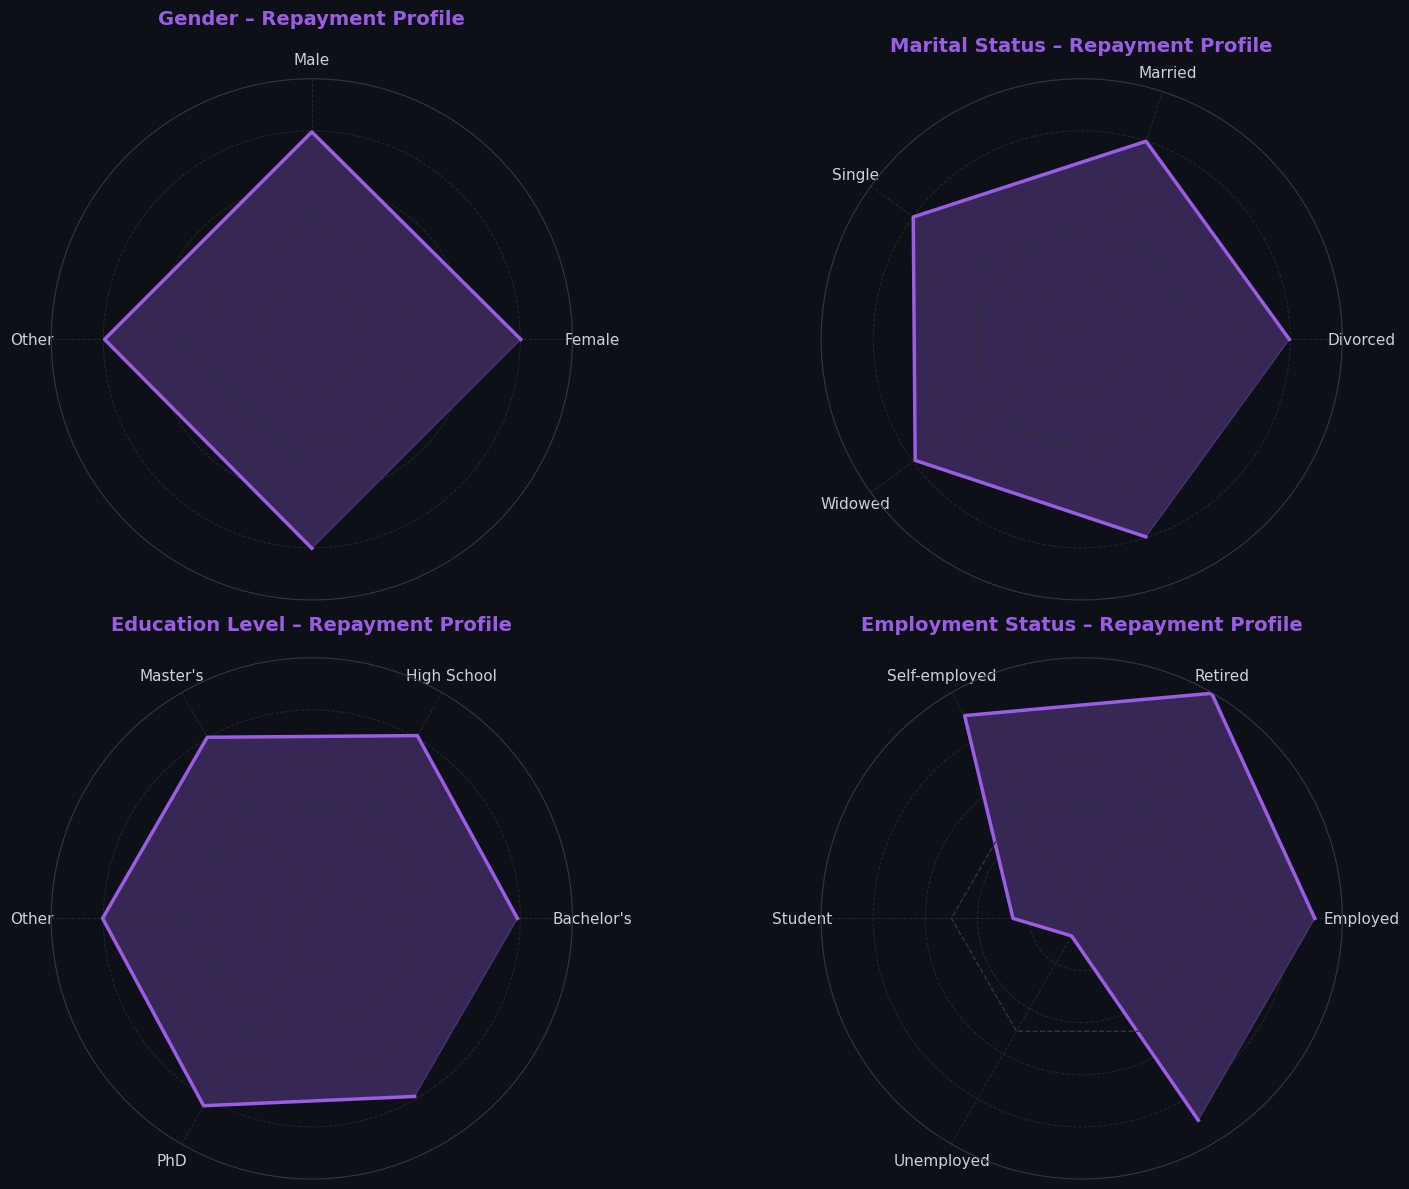

In [20]:
from math import pi

# Neon colors
color_0 = "#00f5d4"   # Not Paid Back
color_1 = "#9b5de5"   # Paid Back

fig = plt.figure(figsize=(16, 12), facecolor="#0d1117")
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, col in enumerate(categorical_cols):
    ax = fig.add_subplot(2, 2, idx + 1, projection='polar')
    ax.set_facecolor("#0d1117")

    # Compute category-wise repayment percentage
    data = train_df.groupby(col)[target_col].mean() * 100
    categories = data.index.tolist()
    values = data.values.tolist()

    # Close the circle
    categories += [categories[0]]
    values += [values[0]]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]

    # Plot line
    ax.plot(angles, values, color=color_1, linewidth=2.5)
    ax.fill(angles, values, color=color_1, alpha=0.3)

    # Baseline (50% marked)
    ax.plot(angles, [50] * len(angles), linestyle="--", 
            linewidth=1, color="#30363d")

    # Customize labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories[:-1], color="#c9d1d9", fontsize=11)

    # Radial grid color
    ax.xaxis.grid(True, color="#30363d", linestyle="--", linewidth=0.7, alpha=0.6)
    ax.yaxis.grid(True, color="#30363d", linestyle="--", linewidth=0.7, alpha=0.6)

    # Y-label styling
    ax.set_yticklabels([])
    ax.set_ylim(0, 100)

    # Title
    ax.set_title(
        f"{col.replace('_', ' ').title()} – Repayment Profile",
        fontsize=14, color="#9b5de5", pad=20, weight="600"
    )

plt.tight_layout()
plt.show()


## Data preprocessing

In [21]:
rounding_dict = {'1s': 0, '10s': -1}  # Key = suffix, Value = decimals

for column in ['annual_income', 'loan_amount']:
    for suffix, decimals in rounding_dict.items():
        for dataset in [train_df, test_df]:
            dataset[f'{column}_ROUND_{suffix}'] = dataset[column].round(decimals).astype(int)


for dataset in [train_df, test_df]:
    # Subgrade as integer (numeric part)
    dataset['subgrade'] = dataset['grade_subgrade'].str[1:].astype(int)
    # Grade as string (alphabetic part)
    dataset['grade'] = dataset['grade_subgrade'].str[0]


for dataset in [train_df, test_df]:
    dataset['total_debt_burden'] = (
        (dataset['loan_amount'] * dataset['interest_rate'] / 100) /
        (dataset['annual_income'] + 1)  # Avoid division by zero
    )

print("✅ Derived features created successfully!")


✅ Derived features created successfully!


In [22]:
feature_cols = train_df.drop(columns=[target_col, "id"]).columns.tolist()

In [23]:
categorical_features = [
    col for col in feature_cols
    if train_df[col].dtype in ["object", "category"]
]

In [24]:
numeric_features = [
    col for col in feature_cols
    if train_df[col].dtype not in ["object", "category", "bool"]
]

In [25]:
print(f"Total features       : {len(feature_cols)}")
print(f"Categorical features : {len(categorical_features)}")
print(f"Numeric features     : {len(numeric_features)}")

Total features       : 18
Categorical features : 7
Numeric features     : 11


## FEA

In [26]:
from sklearn.model_selection import KFold
def apply_target_encoding(train_data, test_data, feature_list, target_column, n_folds=10):

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_encoded = pd.DataFrame(index=train_data.index)
    test_encoded = pd.DataFrame(index=test_data.index)
    for feature in feature_list:
        # Array to store out-of-fold (OOF) encoded values for train data
        oof_encoding = np.zeros(len(train_data))
        
        # K-Fold encoding for train data
        for train_idx, val_idx in kfold.split(train_data):
            train_fold = train_data.iloc[train_idx]
            val_fold = train_data.iloc[val_idx]
            
            # Calculate mean target for each category in the fold
            target_means = train_fold.groupby(feature)[target_column].mean()
            
            # Map means to validation fold
            oof_encoding[val_idx] = val_fold[feature].map(target_means)
        
        # Store encoded feature in train_encoded DataFrame
        train_encoded[f'mean_{feature}'] = oof_encoding
        
        # Global mean encoding for test data
        global_means = train_data.groupby(feature)[target_column].mean()
        test_encoded[f'mean_{feature}'] = test_data[feature].map(global_means)
    train_data = pd.concat([train_data, train_encoded], axis=1)
    test_data = pd.concat([test_data, test_encoded], axis=1)
    return train_data.copy(), test_data.copy()

In [27]:
def engineer_frequency_features(train_data, test_data, feature_list, numeric_list):
    """
    Create frequency encoding and quantile binning features.
    """
    for col in feature_list:
        value_counts = train_data[col].value_counts()
        train_data[f"{col}_freq"] = train_data[col].map(value_counts)
        test_data[f"{col}_freq"] = test_data[col].map(value_counts).fillna(value_counts.mean())
        
        if col in numeric_list:
            for n_quantiles in [5, 10, 15]:
                try:
                    train_binned, bin_edges = pd.qcut(
                        train_data[col], q=n_quantiles, labels=False, retbins=True, duplicates="drop"
                    )
                    train_data[f"{col}_bin{n_quantiles}"] = train_binned
                    test_data[f"{col}_bin{n_quantiles}"] = pd.cut(
                        test_data[col], bins=bin_edges, labels=False, include_lowest=True
                    )
                except Exception:
                    train_data[f"{col}_bin{n_quantiles}"] = 0
                    test_data[f"{col}_bin{n_quantiles}"] = 0
    
    return train_data, test_data

### Pipeline

In [28]:
print("Applying target encoding...")
train_df, test_df = apply_target_encoding(train_df, test_df, feature_cols, target_col)

Applying target encoding...


In [29]:
print("Applying frequency encoding and binning...")
train_df, test_df = engineer_frequency_features(train_df, test_df, feature_cols, numeric_features)

Applying frequency encoding and binning...


In [30]:
train_df[categorical_features] = train_df[categorical_features].astype("category")
test_df[categorical_features] = test_df[categorical_features].astype("category")

In [31]:
print("Feature engineering completed!")

Feature engineering completed!


In [32]:
features_to_remove = [
    'annual_income_ROUND_10s_bin10', 'annual_income_ROUND_1s_bin10', 
    'annual_income_ROUND_1s_bin15', 'annual_income_ROUND_1s_bin5',
    'annual_income_bin10', 'annual_income_bin5', 'credit_score_bin10', 
    'credit_score_bin5', 'debt_to_income_ratio_bin15', 'debt_to_income_ratio_bin5',
    'education_level_freq', 'gender_freq', 'interest_rate_bin10', 
    'interest_rate_bin5', 'loan_amount_ROUND_10s_bin5', 'loan_amount_ROUND_1s_bin10',
    'loan_amount_ROUND_1s_bin15', 'loan_amount_ROUND_1s_bin5', 'loan_amount_bin10', 
    'loan_amount_bin15', 'loan_amount_bin5', 'marital_status_freq',
    'subgrade', 'subgrade_bin10', 'subgrade_bin15', 'subgrade_bin5', 
    'subgrade_freq', "mean_total_debt_burden"
]


In [33]:
train_df = train_df.drop(columns=features_to_remove + ["id"])
test_df = test_df.drop(columns=features_to_remove)

In [34]:
print(f"Features after selection: {len(train_df.columns)}")

Features after selection: 60


## Missing values

In [35]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if not missing_values.empty:
    print("Features with missing values:")
    print(missing_values)
else:
    print("✅ No missing values found.")


Features with missing values:
mean_annual_income              83864
mean_loan_amount                72382
mean_annual_income_ROUND_1s     11740
mean_loan_amount_ROUND_1s        4303
mean_annual_income_ROUND_10s     1680
mean_loan_amount_ROUND_10s        187
mean_interest_rate                 97
mean_debt_to_income_ratio          25
mean_credit_score                  14
dtype: int64


## Model training

In [36]:
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Create LightGBM dataset
lgb_dataset = lgb.Dataset(X, label=y, free_raw_data=True)

# Model hyperparameters
model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'max_depth': 6,
    'num_leaves': 50,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'min_child_samples': 20,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'device': 'gpu',
    'verbose': -1,
}

print("Model parameters configured!")

Model parameters configured!


In [37]:
model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',  
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'device': 'cpu',          
    'verbose': -1
}


## Cross validation

In [38]:
# Run cross-validation to find optimal number of iterations
print("Starting cross-validation...")
cv_results = lgb.cv(
    params=model_params,
    train_set=lgb_dataset,
    num_boost_round=20000,
    nfold=7,
    stratified=True,
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=300)
    ],
    seed=42
)

# Display CV results
cv_summary = pd.DataFrame(cv_results)
print("\nCross-validation summary (last 5 rounds):")
print(cv_summary.tail())

# Identify optimal iteration
optimal_iterations = len(cv_results['valid auc-mean'])
best_cv_score = cv_results['valid auc-mean'][-1]

print(f"\nOptimal iterations: {optimal_iterations}")
print(f"Best CV AUC: {best_cv_score:.7f}")

Starting cross-validation...
Training until validation scores don't improve for 100 rounds
[300]	valid's auc: 0.927156 + 0.000743088
Early stopping, best iteration is:
[345]	valid's auc: 0.92717 + 0.00074932

Cross-validation summary (last 5 rounds):
     valid auc-mean  valid auc-stdv
340        0.927165        0.000746
341        0.927164        0.000746
342        0.927167        0.000746
343        0.927169        0.000748
344        0.927170        0.000749

Optimal iterations: 345
Best CV AUC: 0.9271700


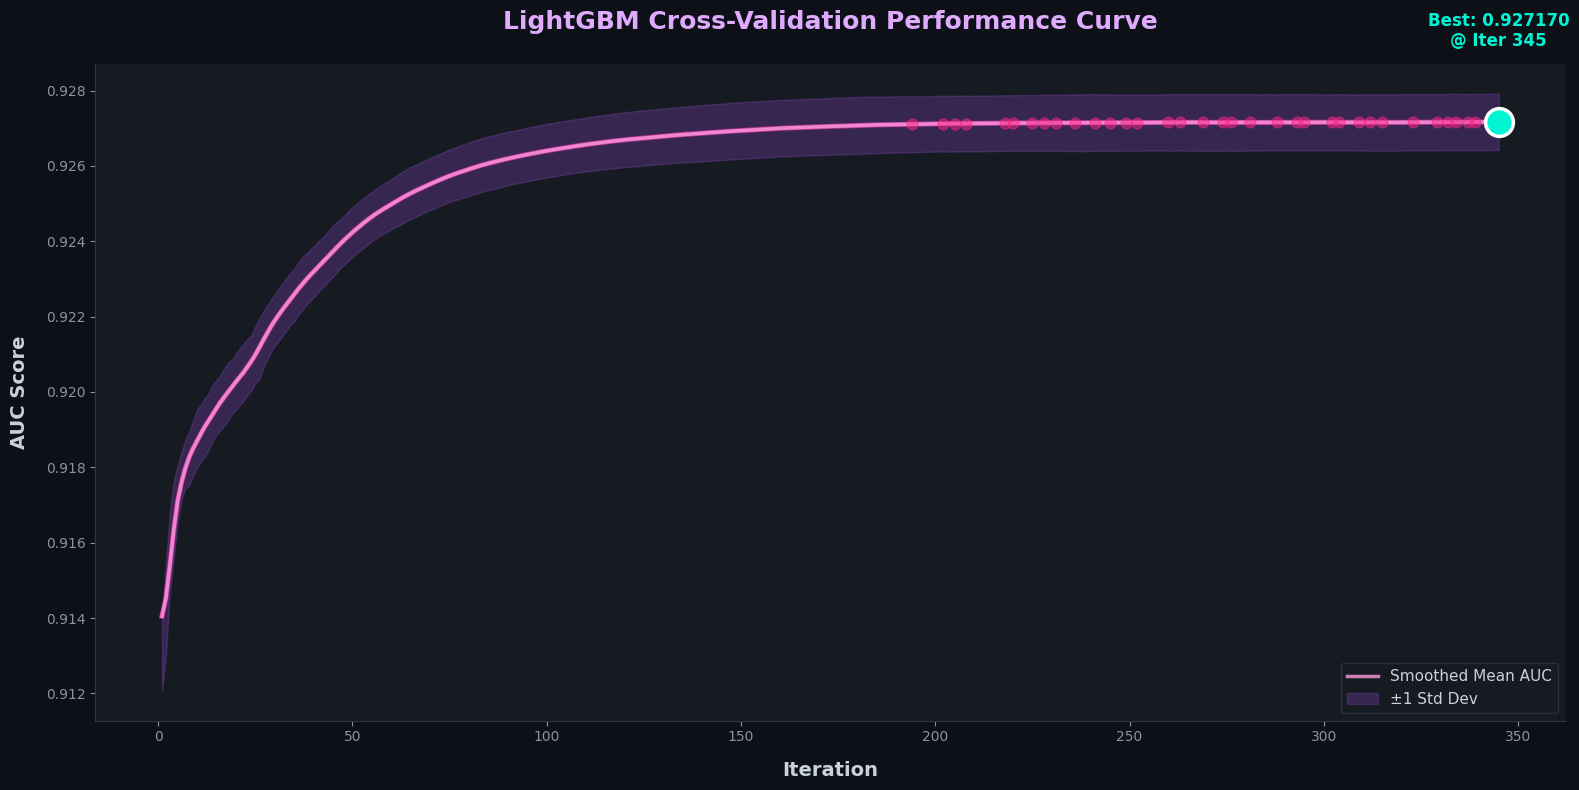

In [39]:
from scipy.ndimage import uniform_filter1d
fig, ax = plt.subplots(figsize=(16, 8), facecolor='#0d1117')
iterations = np.arange(1, len(cv_results['valid auc-mean']) + 1)
mean_auc = np.array(cv_results['valid auc-mean'])
std_auc = np.array(cv_results['valid auc-stdv'])
smooth_mean = uniform_filter1d(mean_auc, size=5)
ax.plot(iterations, smooth_mean, color='#ff00aa', linewidth=4, alpha=0.3, zorder=1)
ax.plot(iterations, smooth_mean, color='#ff66cc', linewidth=3.5, alpha=0.5, zorder=2)
ax.plot(iterations, smooth_mean, color='#ff99dd', linewidth=2.5, alpha=0.8, zorder=3, label='Smoothed Mean AUC')
ax.fill_between(iterations, mean_auc - std_auc, mean_auc + std_auc, 
                color='#9d4edd', alpha=0.25, label='±1 Std Dev', zorder=0)
best_idx = np.argmax(mean_auc)
ax.scatter(iterations[best_idx], mean_auc[best_idx], s=400, 
           color='#00f5d4', edgecolors='#ffffff', linewidth=2.5, zorder=5)
ax.text(iterations[best_idx], mean_auc[best_idx] + 0.002, 
        f'Best: {mean_auc[best_idx]:.6f}\n@ Iter {iterations[best_idx]}', 
        color='#00f5d4', fontsize=12, weight='700', ha='center')
peaks = (np.diff(np.sign(np.diff(mean_auc))) < 0).nonzero()[0] + 1
ax.scatter(iterations[peaks], mean_auc[peaks], s=60, color='#f72585', alpha=0.5, zorder=4)
ax.set_xlabel('Iteration', fontsize=14, color='#c9d1d9', weight='600', labelpad=12)
ax.set_ylabel('AUC Score', fontsize=14, color='#c9d1d9', weight='600', labelpad=12)
ax.set_title('LightGBM Cross-Validation Performance Curve', fontsize=18, 
             color='#e0aaff', pad=25, weight='700')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#30363d')
ax.spines['bottom'].set_color('#30363d')

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.25)
ax.legend(loc='lower right', fontsize=11, frameon=True, 
          facecolor='#161b22', edgecolor='#30363d')

plt.tight_layout()
plt.show()

In [40]:
model_params["n_estimators"] = optimal_iterations + 100
print(f"Final model will use {model_params['n_estimators']} estimators")

Final model will use 445 estimators


In [41]:
from lightgbm import LGBMClassifier
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("🔹 Training final LightGBM model on full dataset...")
final_model = LGBMClassifier(**model_params)
final_model.fit(X_train, y_train)
X_test = test_df.drop(columns=["id"])
print("🔹 Generating predictions on test set...")
test_predictions = final_model.predict_proba(X_test)[:, 1]

print("✅ Predictions completed successfully!")


🔹 Training final LightGBM model on full dataset...
🔹 Generating predictions on test set...
✅ Predictions completed successfully!


## FEA Analysis

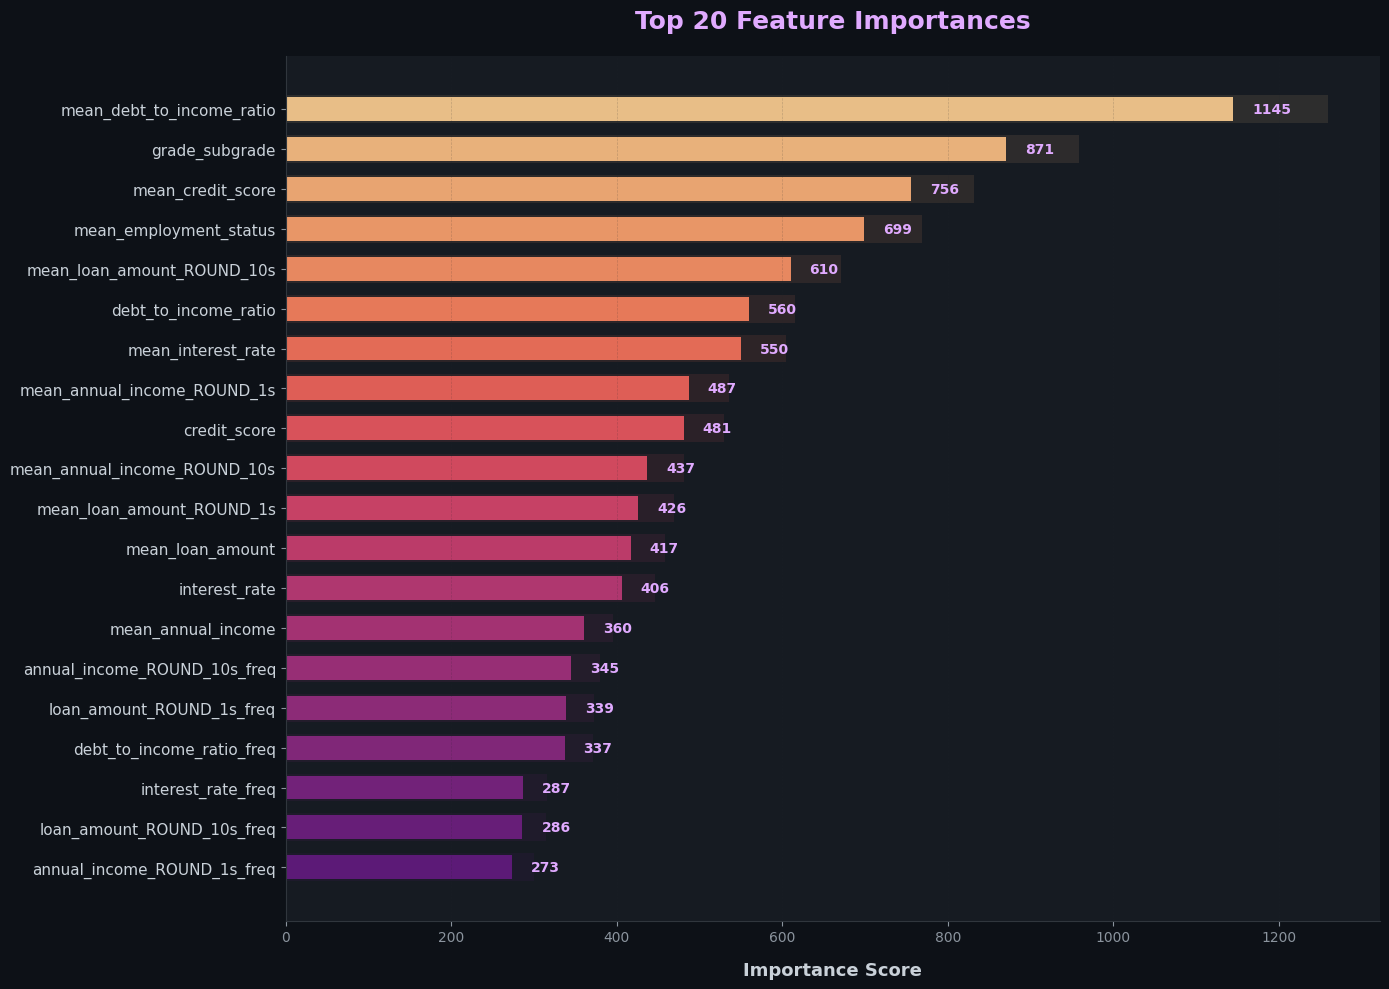


Top 20 Feature Importances:
                     feature  importance
   mean_debt_to_income_ratio        1145
              grade_subgrade         871
           mean_credit_score         756
      mean_employment_status         699
  mean_loan_amount_ROUND_10s         610
        debt_to_income_ratio         560
          mean_interest_rate         550
 mean_annual_income_ROUND_1s         487
                credit_score         481
mean_annual_income_ROUND_10s         437
   mean_loan_amount_ROUND_1s         426
            mean_loan_amount         417
               interest_rate         406
          mean_annual_income         360
annual_income_ROUND_10s_freq         345
   loan_amount_ROUND_1s_freq         339
   debt_to_income_ratio_freq         337
          interest_rate_freq         287
  loan_amount_ROUND_10s_freq         286
 annual_income_ROUND_1s_freq         273


In [42]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True).tail(20)  # ascending for horizontal bar plot

fig, ax = plt.subplots(figsize=(14, 10), facecolor='#0d1117')

# Color gradient
colors = plt.cm.magma(np.linspace(0.3, 0.9, len(feature_importance)))

# Positions
y_pos = np.arange(len(feature_importance))
for i, (feat, imp) in enumerate(zip(feature_importance['feature'], feature_importance['importance'])):
    # Outer glow
    ax.barh(y_pos[i], imp*1.1, color=colors[i], alpha=0.1, edgecolor='none', height=0.7)
    # Main bar
    ax.barh(y_pos[i], imp, color=colors[i], alpha=0.9, edgecolor='none', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance['feature'], fontsize=11, color='#c9d1d9')
ax.set_xlabel('Importance Score', fontsize=13, color='#c9d1d9', weight='600', labelpad=12)
ax.set_title('Top 20 Feature Importances', fontsize=18, color='#e0aaff', pad=20, weight='700')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#30363d')
ax.spines['bottom'].set_color('#30363d')
ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.2)
max_imp = feature_importance['importance'].max()
for i, val in enumerate(feature_importance['importance']):
    ax.text(val + max_imp*0.02, y_pos[i], f'{val:.0f}', color='#e0aaff', 
            va='center', fontsize=10, weight='600')

plt.tight_layout()
plt.show()
print("\nTop 20 Feature Importances:")
print(feature_importance.sort_values('importance', ascending=False).to_string(index=False))

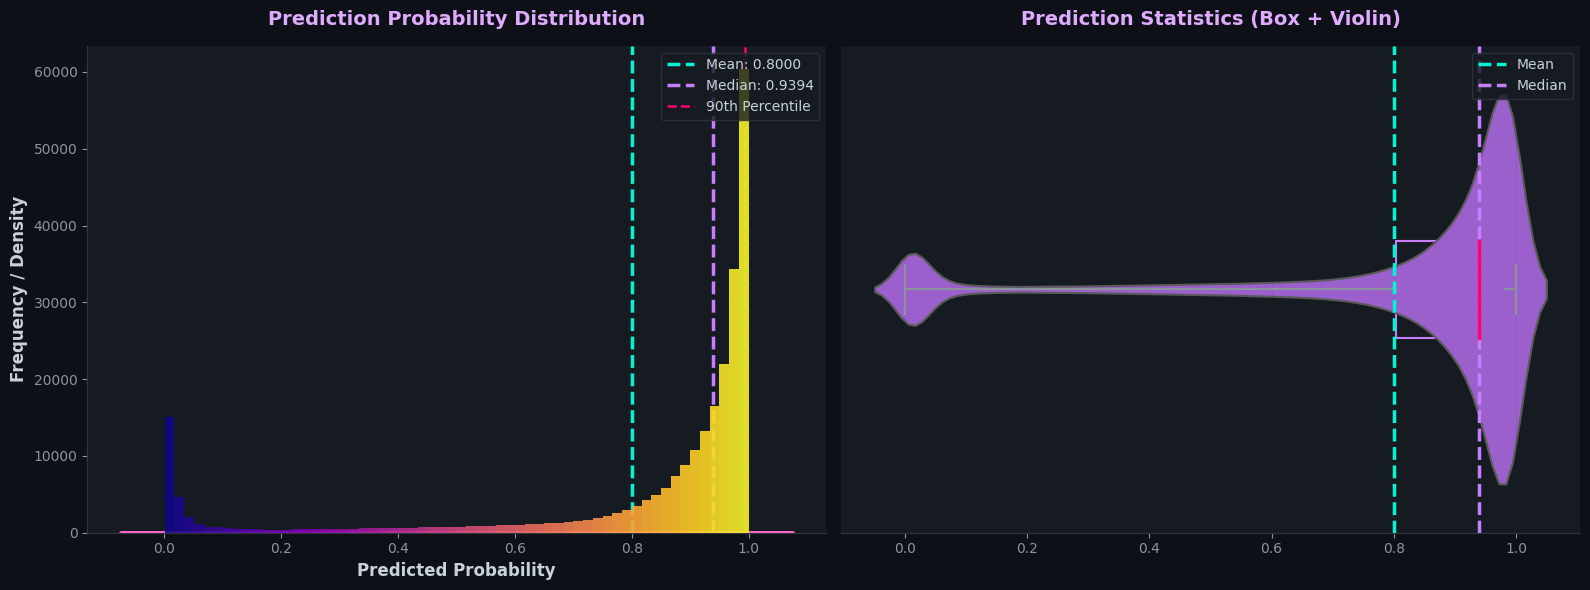


Prediction Statistics:
Mean      : 0.800008
Median    : 0.939436
Std       : 0.302032
Min       : 0.000641
Max       : 0.999746
90th perc.: 0.993367


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='#0d1117')
fig.subplots_adjust(wspace=0.35)
ax1 = axes[0]
sns.kdeplot(test_predictions, ax=ax1, color='#ff66cc', lw=3, fill=True, alpha=0.3, zorder=2)

n, bins, patches = ax1.hist(test_predictions, bins=60, color='#9d4edd', alpha=0.9, edgecolor='none', zorder=3)

# Gradient coloring for bars
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.plasma(i / len(patches)))

mean_pred = test_predictions.mean()
median_pred = np.median(test_predictions)

ax1.axvline(mean_pred, color='#00f5d4', linestyle='--', lw=2.5, label=f'Mean: {mean_pred:.4f}')
ax1.axvline(median_pred, color='#c77dff', linestyle='--', lw=2.5, label=f'Median: {median_pred:.4f}')
ax1.axvline(np.percentile(test_predictions, 90), color='#ff006e', linestyle='--', lw=1.8, label='90th Percentile')

ax1.set_xlabel('Predicted Probability', fontsize=12, color='#c9d1d9', weight='600')
ax1.set_ylabel('Frequency / Density', fontsize=12, color='#c9d1d9', weight='600')
ax1.set_title('Prediction Probability Distribution', fontsize=14, color='#e0aaff', pad=15, weight='600')
ax1.legend(loc='upper right', frameon=True, facecolor='#161b22', edgecolor='#30363d', fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#30363d')
ax1.spines['bottom'].set_color('#30363d')
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax2 = axes[1]
sns.violinplot(x=test_predictions, ax=ax2, inner=None, color='#9d4edd', alpha=0.7)
sns.boxplot(x=test_predictions, ax=ax2, whis=[0,100], width=0.2, boxprops=dict(facecolor='#161b22', edgecolor='#c77dff'),
            whiskerprops=dict(color='#8b949e'), capprops=dict(color='#8b949e'), medianprops=dict(color='#ff006e', lw=2.5))

# Highlight mean and median
ax2.axvline(mean_pred, color='#00f5d4', lw=2.5, linestyle='--', label='Mean')
ax2.axvline(median_pred, color='#c77dff', lw=2.5, linestyle='--', label='Median')

ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_title('Prediction Statistics (Box + Violin)', fontsize=14, color='#e0aaff', pad=15, weight='600')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_color('#30363d')
ax2.grid(True, alpha=0.2, axis='x', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right', frameon=True, facecolor='#161b22', edgecolor='#30363d', fontsize=10)

plt.tight_layout()
plt.show()
print("\nPrediction Statistics:")
print(f"Mean      : {mean_pred:.6f}")
print(f"Median    : {median_pred:.6f}")
print(f"Std       : {test_predictions.std():.6f}")
print(f"Min       : {test_predictions.min():.6f}")
print(f"Max       : {test_predictions.max():.6f}")
print(f"90th perc.: {np.percentile(test_predictions, 90):.6f}")

## Submission file!

In [44]:
submission = pd.DataFrame({
    "id": test_df["id"],
    target_col: test_predictions
})

# Save submission
submission.to_csv("submission.csv", index=False)
print("✓ Submission file created successfully!")
print(f"✓ Total predictions: {len(submission)}")
print(f"\nSubmission preview:")
print(submission.head(10))

✓ Submission file created successfully!
✓ Total predictions: 254569

Submission preview:
       id  loan_paid_back
0  593994        0.924241
1  593995        0.975822
2  593996        0.447494
3  593997        0.919335
4  593998        0.969511
5  593999        0.974526
6  594000        0.980844
7  594001        0.975878
8  594002        0.970778
9  594003        0.004434


## Thank you...pls upvote!!!!